# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [1]:
# Autograd & Numpy
%pip install autograd
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

Note: you may need to restart the kernel to use updated packages.


### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [2]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [3]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [4]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
g = autograd.grad
print(g(f,0)(0.0,0.0))

1.0


In [5]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [6]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [7]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

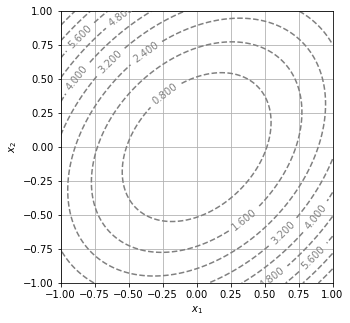

In [8]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [9]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

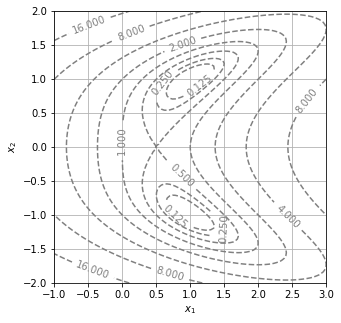

In [10]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [11]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

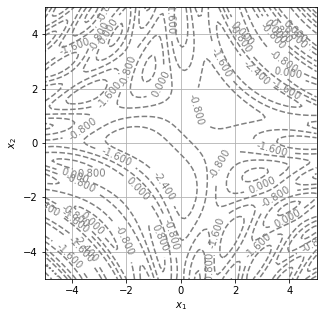

In [12]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

*Réponse* : On souhaite avoir une précision accrue car il s'agit pleinement de construire nos courbes de niveau. Pour les fonctions introduites, les valeurs atteintes peuvent décrire jusqu'à [0 ; 0,125] sur une partie majeure de la figure. Ainsi, nous optons pour un ordre de grandeur raisonnable pour la précision de 0,0001.

In [13]:
N = 1000
eps = 0.0001

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

*Réponse* :

In [14]:
def inv_J(x,y,F) :
    "A partir d'une fonction et d'un point du plan, retourne l'inverse de la jacobienne de cette fonction en ce point"
    J_F = J(F)
    a, b, c, d = J_F(x,y)[0,0] , J_F(x,y)[0,1], J_F(x,y)[1,0], J_F(x,y)[1,1]
    return 1/(a*d - b*c) * np.array([[d,-b],[-c,a]])

In [15]:
def Newton(F, x0, y0, eps=eps, N=N):
    "Implémente la méthode de Newton avec la précision eps"
    x, y = x0, y0
    J_F = J(F)
    for i in range(N):
        produit = np.dot(inv_J(x,y,F), F(x,y))
        x = x - produit[0]
        y = y - produit[1]
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

*Réponse* :

In [16]:
def F1(x,y) :
    "Fonction adaptant la méthode de Newton pour les fonctions de R^2 dans R comme f1, utilisée pour"
    "le point de la courbe de niveau 0.8 vérifiant x = y"
    return np.array([f1(x,y) - 0.8, x-y])
Newton(F1, 0.8,0.8,eps,N)

(0.4472135970019964, 0.4472135970019964)

Pour d'autres points de référence :

In [17]:
point = np.linspace(0.1,1.0,10)
X = [Newton(F1, x, x, eps, N)[0] for x in point]
Y = [Newton(F1, x, x, eps, N)[1] for x in point]

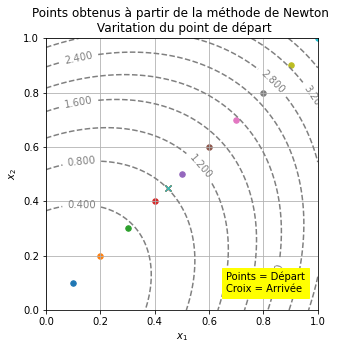

In [18]:
display_contour(
    f1, 
    x=np.linspace(-0., 1.0, 100), 
    y=np.linspace(-0., 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)
for k in range(len(point)) :
    plt.scatter(point[k],point[k],30) # point de départ
    plt.plot(X[k],Y[k],'x') # point d'arrivée
plt.title('Points obtenus à partir de la méthode de Newton \n Varitation du point de départ')
plt.figtext(0.635, 0.175, 'Points = Départ\nCroix = Arrivée',backgroundcolor = 'yellow')
plt.show()

On remarque que la méthode de Newton converge dans ce cas pour une large variété de point initiaux.

Pour d'autres contraintes supplémentaires :

In [19]:
def F1bis(x,y) :
    "Fonction adaptant la méthode de Newton pour les fonctions de R^2 dans R comme f1, utilisée pour"
    "le point de la courbe de niveau 0.8 vérifiant x = -2y"
    return np.array([f1(x,y) - 0.8, x + 2*y])
def F1ter(x,y) :
    "Fonction adaptant la méthode de Newton pour les fonctions de R^2 dans R comme f1, utilisée pour"
    "le point de la courbe de niveau 0.8 vérifiant x = -2y"
    return np.array([f1(x,y) - 0.8, x**2 - np.sqrt(y)])

In [20]:
# Opérons la méthode de Newton basée sur ces fonctions à partir du point de départ (0.1,0.1)
X = [Newton(F1, 0.1, 0.1, eps, N)[0],Newton(F1bis, 0.1, 0.1, eps, N)[0],Newton(F1ter, 0.1, 0.1, eps, N)[0]]
Y = [Newton(F1, 0.1, 0.1, eps, N)[1],Newton(F1bis, 0.1, 0.1, eps, N)[1],Newton(F1ter, 0.1, 0.1, eps, N)[1]]

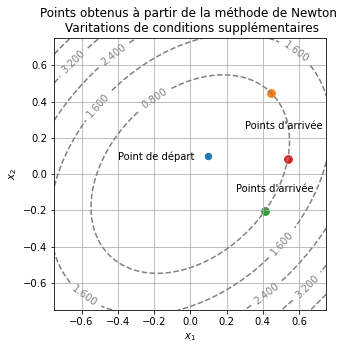

In [21]:
display_contour(
    f1, 
    x=np.linspace(-0.75, 0.75, 100), 
    y=np.linspace(-0.75, 0.75, 100), 
    levels=5
)
plt.scatter(0.1,0.1,s=40) # point de départ
plt.text(-0.4, 0.08, 'Point de départ')
for k in range(len(X)) :
    plt.scatter(X[k],Y[k],s=60) # point d'arrivée
plt.title('Points obtenus à partir de la méthode de Newton \n Varitations de conditions supplémentaires')
plt.text(0.25, -0.1, "Points d'arrivée")
plt.text(0.3, 0.25, "Points d'arrivée")
plt.show()

Ces 3 méthodes convergent bien, et fournissent un point de la courbe de niveau 0.8 répondant au critère imposé.

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

*Réponse* :

In [22]:
def rota(v) :
    "A partir d'un vecteur v, renvoie sa rotation d'un angle de 90° vers la droite"
    theta = np.radians(-90)
    r = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]])
    return r.dot(v)

def G(x0, y0, x1, y1, f, delta, c) :
    "Fonction sur laquelle nous allons opérer la méthode de Newton"
    "Elle porte en elle les 2 conditions : satisfaire la courbe de niveau et se situer à une distance > delta"
    dcarrée = (x1 - x0) ** 2 + (y1 - y0) ** 2
    return np.array([f(x1,y1) - c, dcarrée - delta ** 2])

In [23]:
def level_curve(f, x0, y0, c, delta=0.1, n=200, eps=eps):
    "A partir d'un point initial et d'une fonction f de R^2 dans R, renvoie un tableau"
    "contenant n points de la courbe de niveau c associée à f, à la précison eps"
    points = [[x0,y0]]
    grad_f = grad(f)
    x, y = x0, y0
    tab = np.zeros(2*n).reshape(2,n)
    tab[0,0], tab[1,0] = x0, y0
    for i in range(n-1) :
        perp = rota(grad_f(x,y))
        norme = np.sqrt(perp[0] ** 2 + perp[1] ** 2)
        temp_x, temp_y = x + perp[0] / norme * delta, y + perp[1] / norme * delta
        nouveau_point = Newton(lambda x1,y1 : G(x, y, x1, y1, f, delta, c), temp_x, temp_y) 
        x, y = nouveau_point
        tab[0,i+1], tab[1,i+1] = x, y
    return tab

Traçons la courbe de niveau associée à 0.8 pour la fonction f1

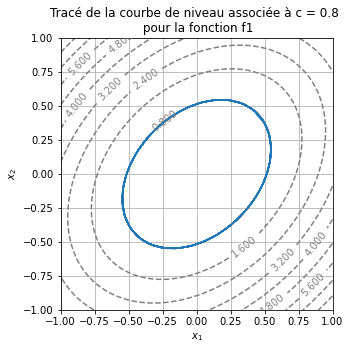

In [24]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10
)
tab = level_curve(f1, 0.44,0.44, 0.8)
plt.plot(tab[0],tab[1])
plt.title('Tracé de la courbe de niveau associée à c = 0.8 \n pour la fonction f1')
plt.show()

Traçons la courbe de niveau associée à 1 pour la fonction f2

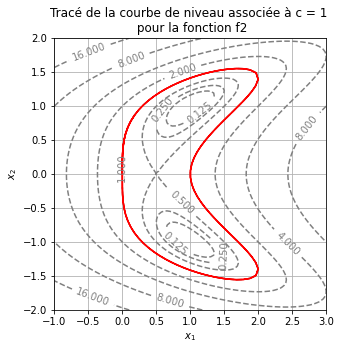

In [25]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)
tab = level_curve(f2, 0.,0., 1.)
plt.plot(tab[0],tab[1],'r')
plt.title('Tracé de la courbe de niveau associée à c = 1 \n pour la fonction f2')
plt.show()

De même pour f3

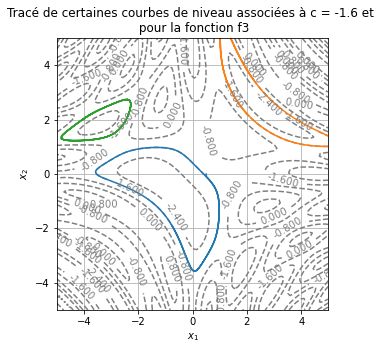

In [26]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)
tab1 = level_curve(f3, 0.5,0., -1.6)
tab2 = level_curve(f3, 2.,2.2, -1.6)
tab3 = level_curve(f3, -4.,2., -1.6)
plt.plot(tab1[0],tab1[1])
plt.plot(tab2[0],tab2[1])
plt.plot(tab3[0],tab3[1])
plt.title('Tracé de certaines courbes de niveau associées à c = -1.6 et \n pour la fonction f3')
plt.axis([-5., 5., -5., 5.])
plt.show()

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

*Réponse* :

In [27]:
def level_curve2(f, x0, y0, c, delta=0.1, n=100, eps=eps):
    "Nouvelle implémentation de la fonction de tracé, empêchant le bouclage en s'arrêtant lorsque le point"
    "en cours de calcul s'approche à moins de delta du premier point déterminé (on aura ainsi effectué une seule boucle)"
    grad_f = grad(f)
    x, y = x0, y0
    tab = np.zeros(2*n).reshape(2,n)
    tab[0,0], tab[1,0] = x0, y0
    j_arret = n
    stop = False
    for i in range(n-1) :
        if not(stop) :    # Tant que l'on a pas bouclé, calcul d'un nouveau point
            perp = rota(grad_f(x,y))
            norme = np.sqrt(perp[0] ** 2 + perp[1] ** 2)
            temp_x, temp_y = x + perp[0] / norme * delta, y + perp[1] / norme * delta
            nouveau_point = Newton(lambda x1,y1 : G(x, y, x1, y1, f, delta, c), temp_x, temp_y) 
            x, y = nouveau_point
            tab[0,i+1], tab[1,i+1] = nouveau_point[0], nouveau_point[1]
        if np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < delta and not(stop) : #Test si ce nouveau point n'est pas trop proche du 1er
            stop = not(stop)
            i_arret = i   # On relève l'indice concerné
    return tab[:,:i_arret+2] # On extrait alors seulement la partie qui nous intéresse

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

*Réponse* :

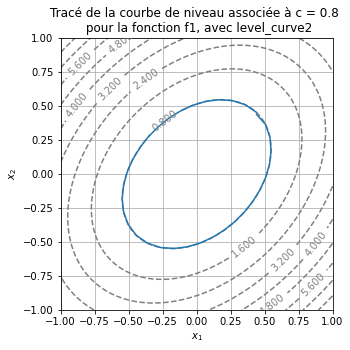

In [28]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10
)
tab = level_curve2(f1, 0.44,0.44, 0.8)
plt.plot(tab[0],tab[1])
plt.title('Tracé de la courbe de niveau associée à c = 0.8 \n pour la fonction f1, avec level_curve2')
plt.show()

Zoomons sur la zone de bouclage pour vérifier si notre démarche est effective.

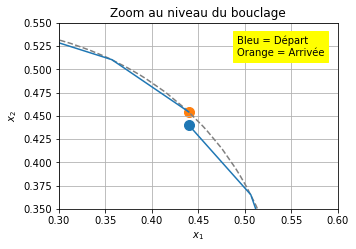

In [29]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10
)
tab = level_curve2(f1, 0.44,0.44, 0.8)
plt.plot(tab[0],tab[1])
plt.scatter(tab[0,0],tab[1,0],s=100)
plt.scatter(tab[0,-1],tab[1,-1],s=100)
plt.axis([0.3, 0.6, 0.35, 0.55])
plt.title('Zoom au niveau du bouclage')
plt.figtext(0.62, 0.67, 'Bleu = Départ\nOrange = Arrivée',backgroundcolor = 'yellow')
plt.show()

On remarque effectivement que le code s'est arrêté du fait de la proximité de ces 2 points, c'est bien ce que l'on recherchait.
Essayons cette méthode pour les autres fonctions.

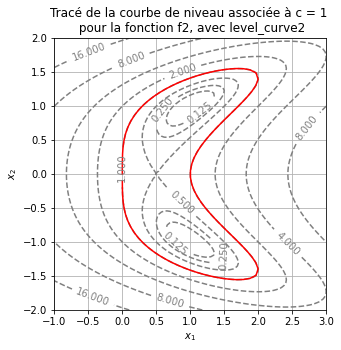

In [30]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)
tab = level_curve2(f2, 0.,0., 1.)
plt.plot(tab[0],tab[1],'r')
plt.title('Tracé de la courbe de niveau associée à c = 1 \n pour la fonction f2, avec level_curve2')
plt.show()

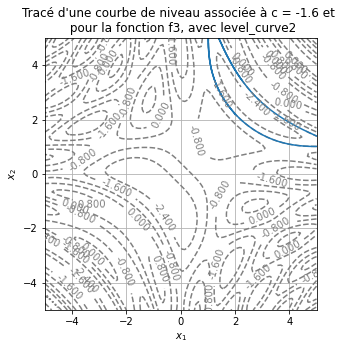

In [31]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)
tab2 = level_curve(f3, 2.,2.2, -1.6)
plt.plot(tab2[0],tab2[1])
plt.title("Tracé d'une courbe de niveau associée à c = -1.6 et \n pour la fonction f3, avec level_curve2")
plt.axis([-5., 5., -5., 5.])
plt.show()

On peut aussi s'assurer de l'efficacité en temps de calcul que cela permet d'obtenir :

In [38]:
import time

start = time.time()
tab = level_curve(f1, 0.44,0.44, 0.8)
end = time.time()
start2 = time.time()
tab = level_curve2(f1, 0.44,0.44, 0.8)
end2 = time.time()
print("Le calcul de l'ensemble des points pour l'exemple de f1 est ici :" + str(int(10*(end - start)/(end2 - start2))/10) + " plus efficace")

Le calcul de l'ensemble des points pour l'exemple de f1 est ici :5.3 plus efficace


# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

*Réponse* :

In [33]:
def area_squares(f,c,h) :
    "Renvoie l'aire approchée de l'ensemble de sous-niveau de f associée à c" 
    "à l'aide de la méthode des carrés pour un pas h"
    def F(x,y,c=c) :
        "Fonction des 2 conditions pour la méthode de Newton"
        return np.array([f(x,y) - c, x-y])
    tab = level_curve2(f, Newton(F, c, c,eps,N)[0],Newton(F, c, c,eps,N)[1], c)
    xmin, xmax = np.min(tab[0]), np.max(tab[0]) 
    ymin, ymax = np.min(tab[1]), np.max(tab[1])
    cote = max(xmax - xmin, ymax - ymin) # Construction du carré recouvrant l'ensemble délimité par la courbe de niveau
    square1 = np.linspace(np.floor(10000 *xmin)/10000, np.floor(10000 * (xmin + cote) + 1)/10000, int(cote/h))  # Tableau des abscisses des petits carrés
    square2 = np.linspace(np.floor(10000 * ymin)/10000, np.floor(10000 * (ymin + cote) + 1)/10000, int(cote/h)) # Tableau des ordonnées des petits carrés
    n = int(np.floor(cote/h))
    square = np.empty((n,n,2)) # Tableau des coordonnées des carrés de côté h
    for i in range(n) :
        for j in range(n) :
            square[i,j,0] = square1[j] + h/2
            square[i,j,1] = square2[i] + h/2
    proportion = np.sum(f(square[:,:,0],square[:,:,1]) <= c) / np.size(square[:,:,0]) # Calcul de la proportion recouverte à l'aide d'un masque
    return proportion * (cote ** 2) # Conversion à l'aide de l'aire totale

Appliquons cette méthode pour déterminer l'aire du disque unité

In [34]:
def disque(x,y) :
    return (x ** 2) + (y ** 2)

In [35]:
print("Pour des carrés de côté h = 0.001, l'aire déterminée est de : "+str(area_squares(disque,1.,0.001)))

Pour des carrés de côté h = 0.001, l'aire déterminée est de : 3.1382849701029323


Notre fonction donne une approximation non aberrante, évaluons alors le comportement de la suite des aires approximées en fonction de h :

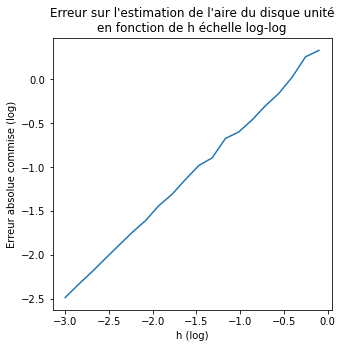

In [36]:
liste_h = [10**(-n) for n in np.linspace(0.1,3,20)]
liste_Ah = [area_squares(disque,1.,h) for h in liste_h]
liste_log = np.log10(liste_h)
xmin, xmax, ymin, ymax = -3., 0.3, 1., 3.8
plt.plot(liste_log,np.log10([abs(Ah - np.pi) for Ah in liste_Ah]))
#plt.axis([xmin,xmax,ymin,ymax])
plt.title("Erreur sur l'estimation de l'aire du disque unité\nen fonction de h échelle log-log")
plt.xlabel('h (log)')
plt.ylabel('Erreur absolue commise (log)')
plt.show()

On remarque clairement que l'affinage de la précision améliore sensiblement l'approximation de l'aire, on peut même affirmer qu'elle s'optimise de manière logarithmique de base 10 (on obtient une droite).

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


*Réponse* : On peut alors balayer un ensemble de précision en h de manière décroissante, et évaluer l'erreur commise jusqu'à ce que l'on obtienne la précision en A voulue. Application pour l'ensemble de sous-niveau du disque unité :

In [37]:
erreur = 1
n = 0
while erreur > 0.01 :
    h = 10 ** (-n)
    Ah = area_squares(disque,1.,h)
    erreur = abs(np.pi - Ah)
    n = n + 0.1
print("Estimation de l'aire à 10^-2 près : "+str(Ah))

Estimation de l'aire à 10^-2 près : 3.133588232576799


## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)